In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import seaborn as sb         # 一个构建在matplotlib上的绘画模块，支持numpy,pandas等数据结构
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix     # 混淆矩阵

import itertools
#  keras
from keras.utils import to_categorical         #数字标签转化成one-hot编码
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

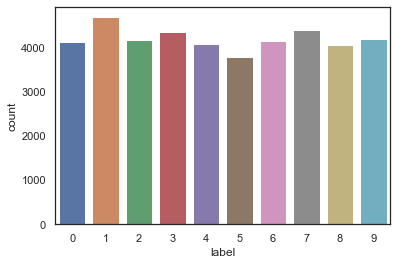

In [2]:
# 设置绘画风格
sb.set(style='white', context='notebook', palette='deep')
# 加载数据
train_data = pd.read_csv('./CNN for MINST dataset/train.csv')
test_data = pd.read_csv('./CNN for MINST dataset/test.csv')
#train_x = train_data.drop(labels=['label'],axis=1)  # 去掉标签列
train_x = train_data.iloc[:,1:]
train_y = train_data.iloc[:,0]
del  train_data   # 释放一下内存
# 观察一下训练数据的分布情况
g = sb.countplot(train_y)
train_y.value_counts()

In [3]:
train_x.isnull().describe() # 检查是否存在缺失值值

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000,42000,42000,42000,42000,42000,42000,42000,42000,42000,...,42000,42000,42000,42000,42000,42000,42000,42000,42000,42000
unique,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,42000,42000,42000,42000,42000,42000,42000,42000,42000,42000,...,42000,42000,42000,42000,42000,42000,42000,42000,42000,42000


In [4]:
train_x.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [5]:
# 归一化
train_x =  train_x/255.0
test_x = test_data/255.0
del test_data

### 转换数据的shape

In [6]:
# reshape trian_x, test_x
#train_x = train_x.values.reshape(-1, 28, 28, 1)
#test_x = test_x.values.reshape(-1, 28, 28, 1)
train_x = train_x.as_matrix().reshape(-1, 28, 28, 1)
test_x = test_x.as_matrix().reshape(-1, 28, 28, 1)
# 吧标签列转化为one-hot 编码格式
train_y = to_categorical(train_y, num_classes = 10)

C:\Users\admin\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
C:\Users\admin\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


### 从数据中分离出验证数据

In [7]:
#从训练数据中分出十分之一的数据作为验证数据
random_seed = 3
train_x , val_x , train_y, val_y = train_test_split(train_x, train_y, test_size=0.1, random_state=random_seed)

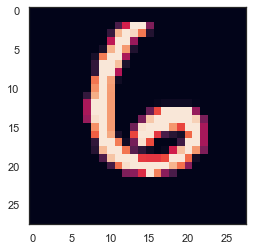

In [8]:
plt.imshow(train_x[0][:,:,0])

### 使用Keras搭建CNN

In [9]:
model = Sequential()
# 第一个卷积层，32个卷积核，大小５x5，卷积模式SAME,激活函数relu,输入张量的大小
model.add(Conv2D(filters= 32, kernel_size=(5,5), padding='Same', activation='relu',input_shape=(28,28,1)))
model.add(Conv2D(filters= 32, kernel_size=(5,5), padding='Same', activation='relu'))
# 池化层,池化核大小２x2
model.add(MaxPool2D(pool_size=(2,2)))
# 随机丢弃四分之一的网络连接，防止过拟合
model.add(Dropout(0.25))  
model.add(Conv2D(filters= 64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(Conv2D(filters= 64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# 全连接层,展开操作，
model.add(Flatten())
# 添加隐藏层神经元的数量和激活函数
model.add(Dense(256, activation='relu'))    
model.add(Dropout(0.25))
# 输出层
model.add(Dense(10, activation='softmax')) 

In [10]:
# 设置优化器
# lr :学习效率，　decay :lr的衰减值
optimizer = RMSprop(lr = 0.001, decay=0.0)
# 编译模型
# loss:损失函数，metrics：对应性能评估函数
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy',metrics=['accuracy'])

### 创建一个callback类的实例
keras的callback类提供了可以跟踪目标值，和动态调整学习效率

moitor : 要监测的量，这里是验证准确率

matience: 当经过３轮的迭代，监测的目标量，仍没有变化，就会调整学习效率

verbose : 信息展示模式，去０或１

factor :　每次减少学习率的因子，学习率将以lr = lr*factor的形式被减少

mode：‘auto’，‘min’，‘max’之一，在min模式下，如果检测值触发学习率减少。在max模式下，当检测值不再上升则触发学习率减少。

epsilon：阈值，用来确定是否进入检测值的“平原区”

cooldown：学习率减少后，会经过cooldown个epoch才重新进行正常操作

min_lr：学习率的下限

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc', patience = 3,
                                            verbose = 1, factor=0.5, min_lr = 0.00001)
epochs = 40
batch_size = 100

### 数据增强处理
数据增强处理，提升模型的泛化能力，也可以有效的避免模型的过拟合

rotation_range : 旋转的角度

zoom_range : 随机缩放图像

width_shift_range : 水平移动占图像宽度的比例

height_shift_range 

horizontal_filp : 水平反转

vertical_filp : 纵轴方向上反转

In [12]:
data_augment = ImageDataGenerator(rotation_range= 10,zoom_range= 0.1,
                                  width_shift_range = 0.1,height_shift_range = 0.1,
                                  horizontal_flip = False, vertical_flip = False)

#### 训练模型

In [ ]:
history = model.fit_generator(data_augment.flow(train_x, train_y, batch_size=batch_size),
                             epochs= epochs, validation_data = (val_x,val_y),
                             verbose =2, steps_per_epoch=train_x.shape[0]//batch_size,
                             callbacks=[learning_rate_reduction])

Epoch 1/40
 - 499s - loss: 0.4033 - acc: 0.8689 - val_loss: 0.0884 - val_acc: 0.9745
Epoch 2/40
 - 473s - loss: 0.1119 - acc: 0.9656 - val_loss: 0.0526 - val_acc: 0.9840
Epoch 3/40
 - 492s - loss: 0.0804 - acc: 0.9757 - val_loss: 0.0531 - val_acc: 0.9852
Epoch 4/40
 - 496s - loss: 0.0651 - acc: 0.9801 - val_loss: 0.0298 - val_acc: 0.9907
Epoch 5/40
 - 483s - loss: 0.0569 - acc: 0.9830 - val_loss: 0.0373 - val_acc: 0.9900
Epoch 6/40
 - 488s - loss: 0.0523 - acc: 0.9843 - val_loss: 0.0401 - val_acc: 0.9898
Epoch 7/40
 - 477s - loss: 0.0481 - acc: 0.9856 - val_loss: 0.0310 - val_acc: 0.9907

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 8/40
 - 466s - loss: 0.0373 - acc: 0.9886 - val_loss: 0.0286 - val_acc: 0.9926
Epoch 9/40


###### 在训练过程当中，有几次触发学习效率衰减的条件，每当val_acc连续３轮没有增长，就会把学习效率调整为当前的一半，调整之后，val_acc都有明显的增长，但是在最后几轮,模型可能已经收敛．

In [ ]:
# learning curves
fig,ax = plt.subplots(2,1,figsize=(10,10))
ax[0].plot(history.history['loss'], color='r', label='Training Loss')
ax[0].plot(history.history['val_loss'], color='g', label='Validation Loss')
ax[0].legend(loc='best',shadow=True)
ax[0].grid(True)


ax[1].plot(history.history['acc'], color='r', label='Training Accuracy')
ax[1].plot(history.history['val_acc'], color='g', label='Validation Accuracy')
ax[1].legend(loc='best',shadow=True)
ax[1].grid(True)

In [ ]:
# 混淆矩阵
def plot_sonfusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    thresh = cm.max()/2.0
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j], horizontalalignment='center',color='white' if cm[i,j] &gt; thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predict label')

##### 验证数据的混淆矩阵

In [ ]:
pred_y = model.predict(val_x)
pred_label = np.argmax(pred_y, axis=1)
true_label = np.argmax(val_y, axis=1)

confusion_mat = confusion_matrix(true_label, pred_label)

plot_sonfusion_matrix(confusion_mat, classes = range(10))